# Import libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale 
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample

# Data Import

In [2]:
dataset = pd.read_csv("Desktop/jewellery.csv")

##### Optional Drop Column

In [3]:
# Remove the column you want to drop
#column_to_drop = "CustomerID"  # Replace "column_name" with the name of the column you want to remove
#dataset.drop(columns=[column_to_drop], inplace=True)
#column_to_drop = "10"  # Replace "column_name" with the name of the column you want to remove
#dataset.drop(columns=[column_to_drop], inplace=True)

# Data Cleaning

In [4]:
dataset.info()
#Distribution
dataset.describe().transpose()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Age            505 non-null    int64  
 1   Income         505 non-null    int64  
 2   SpendingScore  505 non-null    float64
 3   Savings        505 non-null    float64
dtypes: float64(2), int64(2)
memory usage: 15.9 KB


,count,mean,std,min,25%,50%,75%,max
Age,505.0,59.019802,24.140043,17.0,34.000000,59.000000,85.000000,97.0
Income,505.0,75513.291089,35992.922184,12000.0,34529.000000,75078.000000,107100.000000,142000.0
SpendingScore,505.0,0.505083,0.259634,0.0,0.304792,0.368215,0.768279,1.0
Savings,505.0,11862.455867,4949.229253,0.0,6828.709702,14209.932802,16047.268331,20000.0


### Null Values

In [5]:
dataset.isna().sum()

Age              0
Income           0
SpendingScore    0
Savings          0
dtype: int64

In [6]:
# Calculate the threshold for missing values
threshold = 0.2 * len(dataset)

# Iterate over each column
for column in dataset.columns:
    # Check if the column has missing values
    if dataset[column].isna().sum() > 0:
        # If the column is numerical, fill missing values with column mean
        if dataset[column].dtype in ['int64', 'float64']:
            # If the number of missing values is less than the threshold, drop rows
            if dataset[column].isna().sum() < threshold:
                dataset = dataset.dropna(subset=[column])
            # If the number of missing values is greater than or equal to the threshold, fill with column mean
            else:
                column_mean = dataset[column].mean()
                dataset[column].fillna(column_mean, inplace=True)
        # If the column is categorical, drop rows with missing values
        elif dataset[column].dtype == 'object':
            # If the number of missing values is less than the threshold, drop rows
            if dataset[column].isna().sum() < threshold:
                dataset = dataset.dropna(subset=[column])

# Print modified dataset
print("Modified Dataset:")
if dataset.empty:
    print("No data available.")
else:
    print(dataset.head())

Modified Dataset:
   Age  Income  SpendingScore       Savings
0   58   77769       0.791329   6559.829923
1   59   81799       0.791082   5417.661426
2   62   74751       0.702657   9258.992965
3   59   74373       0.765680   7346.334504
4   87   17760       0.348778  16869.507130


In [7]:
# Check for any remaining missing values
missing_values = dataset.isna().sum().sum()
if missing_values > 0:
    print("Warning: Dataset still contains missing values after cleaning.")


# Feature Engineering 

In [8]:
# Convert the "sales" column to string type if it's not already
#dataset['sales'] = dataset['sales'].astype(str)

# Remove dollar signs and commas, and convert to integers
#dataset['sales'] = dataset['sales'].str.replace('$', '').str.replace(',', '', regex=False).astype(int)

### One Hot Encoder

In [9]:
# Check for categorical variables
categorical_columns = set()

# Add columns with less than 10 unique values
for column in dataset.columns:
    if dataset[column].nunique() < 10:
        categorical_columns.add(column)

# Append columns with object data type
categorical_columns.update(col for col in dataset.select_dtypes(include=['object']).columns.tolist())

# Identify and add true/false columns
true_false_columns = [col for col in dataset.columns if dataset[col].dtype == 'bool']
categorical_columns.update(true_false_columns)

if len(categorical_columns) > 0:
    print("Categorical columns found:")
    for column in categorical_columns:
        print(column)
    
    # Fit the encoder to the categorical columns
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    encoded_columns = encoder.fit_transform(dataset[list(categorical_columns)])

    # Get the feature names from the encoder
    encoded_feature_names = encoder.get_feature_names_out(input_features=list(categorical_columns))

    # Create a DataFrame with the encoded columns and feature names
    encoded_df = pd.DataFrame(encoded_columns, columns=encoded_feature_names, index=dataset.index)

    # Drop original categorical columns
    dataset.drop(columns=categorical_columns, inplace=True)
    
    # Concatenate encoded columns with dataset
    dataset = pd.concat([dataset, encoded_df], axis=1)
    
# Display the modified dataset
print("Modified Dataset:")
if dataset.empty:
    print("No data available.")
else:
    print(dataset.head())

Modified Dataset:
   Age  Income  SpendingScore       Savings
0   58   77769       0.791329   6559.829923
1   59   81799       0.791082   5417.661426
2   62   74751       0.702657   9258.992965
3   59   74373       0.765680   7346.334504
4   87   17760       0.348778  16869.507130


### Binary Variables

In [10]:
binary_variables = []

# Iterate through each column
for column in dataset.columns:
    # Check if the number of unique values is 2 and values are 0 and 1, or if the value is just 0
    if (dataset[column].nunique() == 2 and set(dataset[column]) == {0, 1}) or (dataset[column].nunique() == 1 and set(dataset[column]) == {0}):
        binary_variables.append(column)

# Print binary variables
print("Binary Variables:")
print(binary_variables)

Binary Variables:
[]


In [11]:
missing_values = dataset.isna().sum().sum()
if missing_values > 0:
    print("Warning: Dataset still contains missing values after cleaning.")

### Outlier Detection

#### **Data is scaled in this step***

In [12]:
# Remove NaN values from the dataset
dataset = dataset.dropna()

# Scale the features (X)
scaler = StandardScaler()
scaled_X = pd.DataFrame(scaler.fit_transform(dataset), columns=dataset.columns)

# Initialize KMeans
kmeans = KMeans()
kmeans.fit(scaled_X)

# Get cluster centers
centers = kmeans.cluster_centers_

# Calculate distances of each point to its respective cluster center
distances = np.sqrt(np.sum((scaled_X - centers[kmeans.labels_]) ** 2, axis=1))

# Calculate mean and standard deviation of distances
mean_distance = np.mean(distances)
std_distance = np.std(distances)

# Desired threshold as 2 standard deviations from the mean
desired_threshold = mean_distance + 1 * std_distance

# Use the threshold for outlier detection
outliers_mask = distances > desired_threshold

# Reset index to ensure alignment
dataset.reset_index(drop=True, inplace=True)
outliers_dataset = dataset[outliers_mask]

# Print indices and details of outliers
print("Indices of outliers:", outliers_dataset.index)
print("Details of outliers:")
print(outliers_dataset)

# Remove outliers from the original dataset
dataset = dataset[~outliers_mask]


Indices of outliers: Int64Index([  2,  22,  27,  38,  54,  67,  80,  81,  82,  88,  91, 106, 112,
            118, 122, 141, 151, 164, 173, 176, 182, 190, 193, 196, 204, 205,
            212, 213, 222, 224, 233, 236, 244, 249, 255, 261, 263, 268, 271,
            274, 278, 282, 287, 290, 299, 301, 312, 320, 324, 329, 337, 339,
            352, 353, 354, 367, 377, 380, 382, 392, 400, 402, 407, 410, 417,
            421, 422, 432, 436, 444, 446, 454, 466, 472, 479, 480, 491, 498,
            501],
           dtype='int64')
Details of outliers:
     Age  Income  SpendingScore       Savings
2     62   74751       0.702657   9258.992965
22    53   76667       0.760058   5168.225475
27    55   78761       0.827174   8376.749478
38    39  100540       0.384923  16741.013895
54    53   62117       0.733139   7500.452414
..   ...     ...            ...           ...
479   59   69408       0.879906   6491.771150
480   65   71229       0.787890   9024.337461
491   58   70369       0.904520   7461

# Dimensionality Reduction

In [ ]:
#Check for perfect multicollinearity
correlation_matrix = dataset.corr()
highly_correlated_variables = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname_i = correlation_matrix.columns[i]
            colname_j = correlation_matrix.columns[j]
            highly_correlated_variables.add(colname_i)
            highly_correlated_variables.add(colname_j)
print("Highly correlated variables:", highly_correlated_variables)

# Step 2: Remove constant variables
constant_variables = [col for col in dataset.columns if dataset[col].nunique() == 1]
print("Constant variables:", constant_variables)
dataset.drop(columns=constant_variables, inplace=True)

# Fitting the DBSCAN model

In [13]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

def k_distance_graph(dataset, k_range):
    k_distances = []
    for k in k_range:
        # Compute the k distances for each point
        nbrs = NearestNeighbors(n_neighbors=k+1).fit(dataset)
        distances, _ = nbrs.kneighbors(dataset)
        k_distances.append(distances[:, -1])  # Take the distance of the k-th neighbor
    return k_distances

def plot_k_distance_graph(data):
    nn = NearestNeighbors(n_neighbors=4)
    nbrs = nn.fit(data)
    distances, _ = nbrs.kneighbors(data)

    # Plotting K-distance Graph
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.figure(figsize=(6,6))
    plt.plot(distances)
    plt.title('K-distance Graph')
    plt.xlabel('Data Points sorted by distance')
    plt.ylabel('Epsilon')
    plt.show()


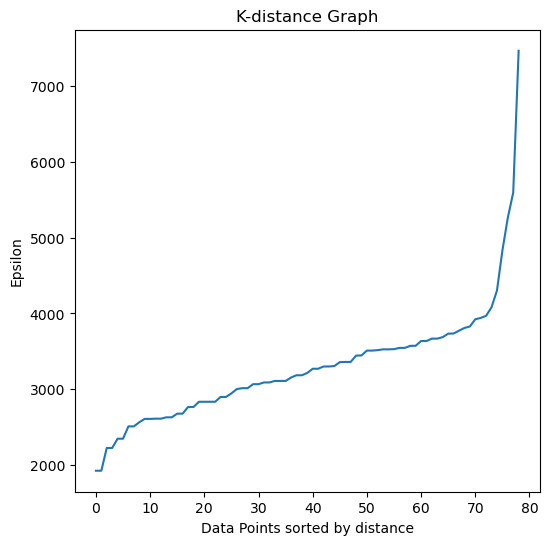

Optimal eps: 3977.979727312068


In [36]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from kneed import KneeLocator

def k_distance_graph(dataset, k_range):
    k_distances = []
    for k in k_range:
        # Compute the k distances for each point
        nbrs = NearestNeighbors(n_neighbors=k+1).fit(dataset)
        distances, _ = nbrs.kneighbors(dataset)
        k_distances.append(distances[:, -1])  # Take the distance of the k-th neighbor
    return k_distances

def plot_k_distance_graph(data):
    nn = NearestNeighbors(n_neighbors=4)
    nbrs = nn.fit(data)
    distances, _ = nbrs.kneighbors(data)

    # Plotting K-distance Graph
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.figure(figsize=(6,6))
    plt.plot(distances)
    plt.title('K-distance Graph')
    plt.xlabel('Data Points sorted by distance')
    plt.ylabel('Epsilon')
    plt.show()

def find_optimal_eps(k_distances):
    avg_distances = np.mean(k_distances, axis=0)
    kneedle = KneeLocator(range(1, len(avg_distances) + 1), avg_distances, curve='convex', direction='decreasing')
    optimal_k = kneedle.elbow
    optimal_eps = avg_distances[optimal_k - 1]  # Get the epsilon value corresponding to the elbow point
    return optimal_eps

# Define the range of k values for k-distance graph
k_range = range(1, 80)

# Generate k-distance graph
k_distances = k_distance_graph(dataset, k_range)

# Plot the k-distance graph
plot_k_distance_graph(k_distances)

# Find the optimal epsilon
optimal_eps = find_optimal_eps(k_distances)
print("Optimal eps:", optimal_eps)


In [37]:
from sklearn.cluster import DBSCAN

# Instantiate and fit the DBSCAN model
dbscan = DBSCAN(eps=3977.979727312068, min_samples=10)
dbscan.fit(dataset)

# Retrieve the labels
labels = dbscan.labels_

# Count the number of clusters (excluding noise points)
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

# Count the number of noise points
n_noise_ = list(labels).count(-1)

# Print the results
print("Estimated number of clusters:", n_clusters_)
print("Estimated number of noise points:", n_noise_)

Estimated number of clusters: 4
Estimated number of noise points: 2


In [40]:
from sklearn.cluster import DBSCAN
dbscan_opt=DBSCAN(eps=3977.979727312068)
dbscan_opt.fit(dataset)

DBSCAN(eps=3977.979727312068)

In [41]:
dataset['DBSCAN_opt_labels']=dbscan_opt.labels_
dataset['DBSCAN_opt_labels'].value_counts()

1    135
0    125
3    122
2     44
Name: DBSCAN_opt_labels, dtype: int64

In [42]:
dataset = dataset.copy ()
dataset ['DBSCAN_opt_labels'] = dbscan_opt.labels_
dataset

,Age,Income,SpendingScore,Savings,DBSCAN_opt_labels
0,58,77769,0.791329,6559.829923,0
1,59,81799,0.791082,5417.661426,0
3,59,74373,0.765680,7346.334504,0
4,87,17760,0.348778,16869.507130,1
5,29,131578,0.847034,3535.514352,2
...,...,...,...,...,...
499,25,128625,0.816739,4914.117127,2
500,28,101206,0.387441,14936.775389,3
502,90,35297,0.355149,16091.401954,1
503,91,20681,0.354679,18401.088445,1


## Clusters

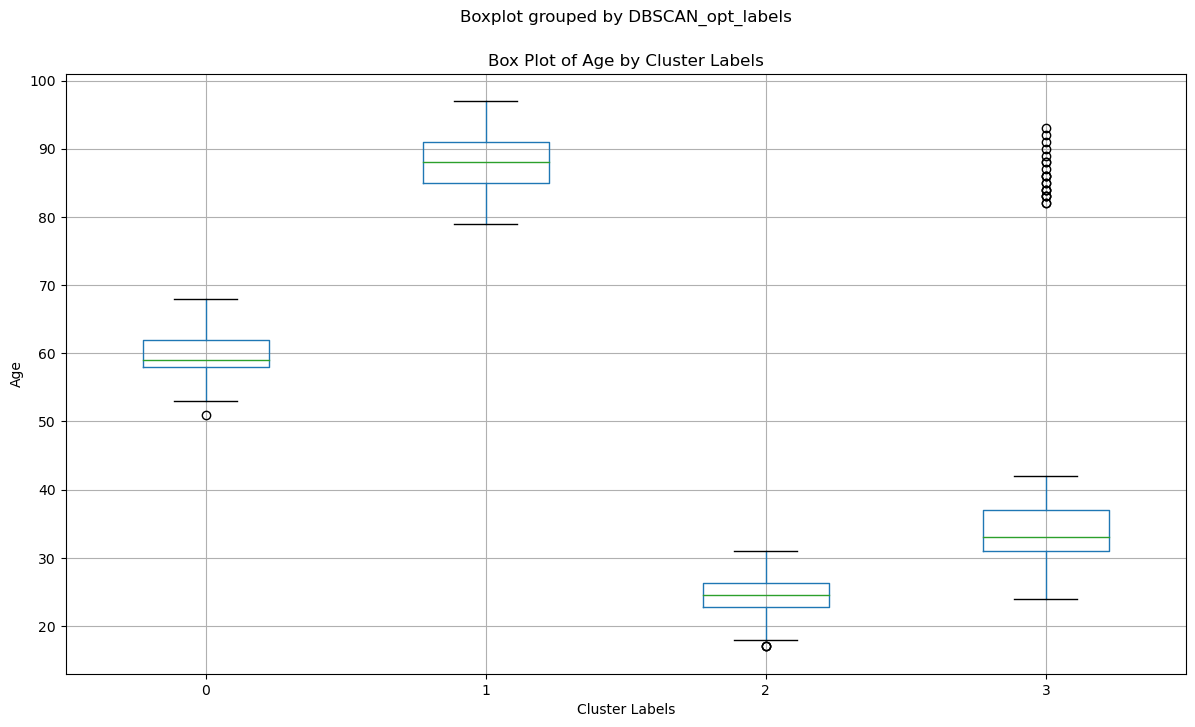

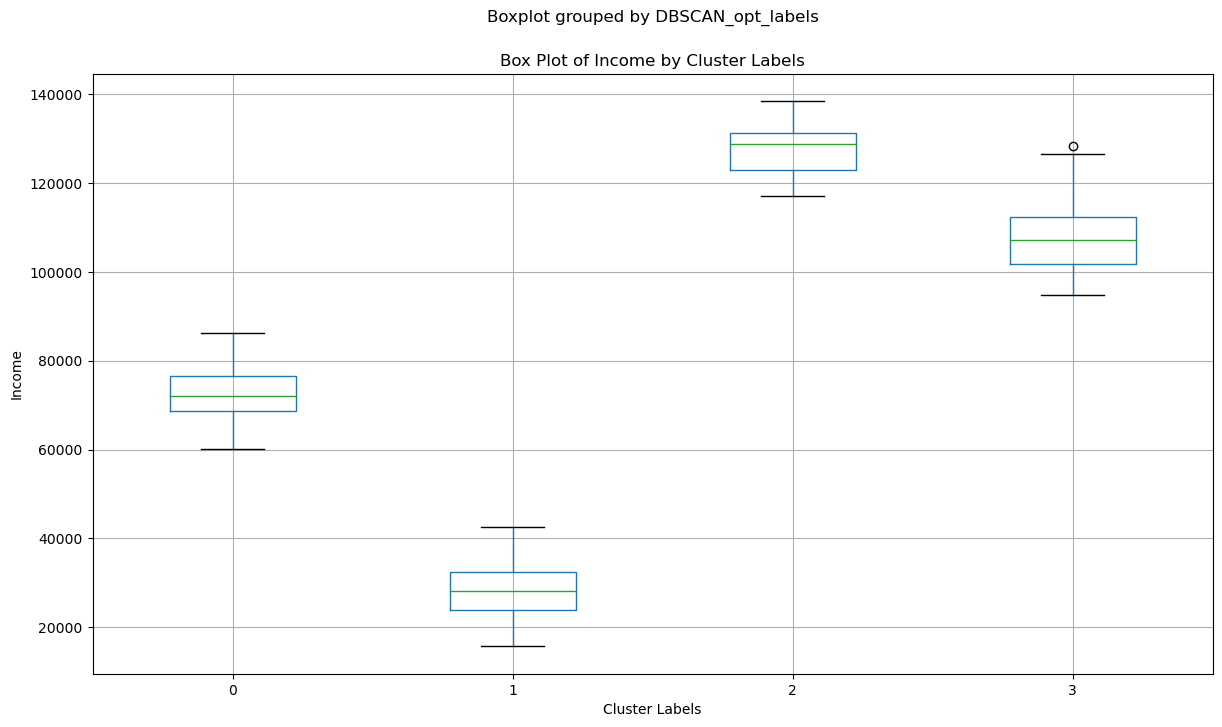

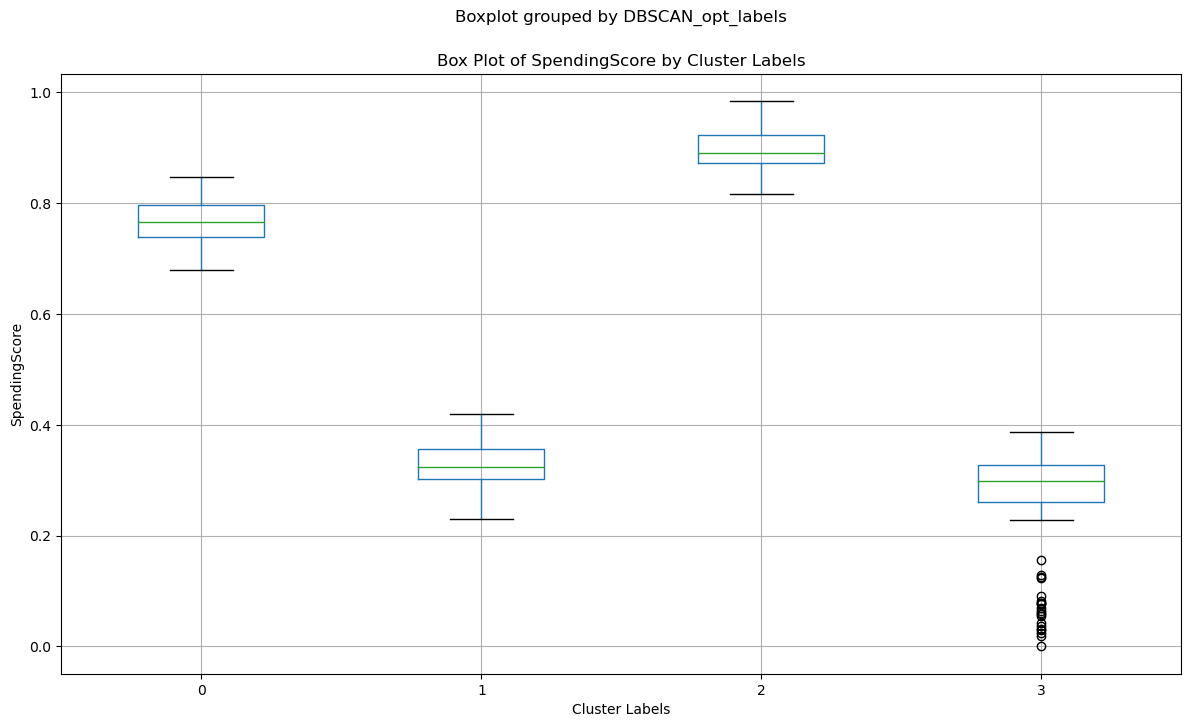

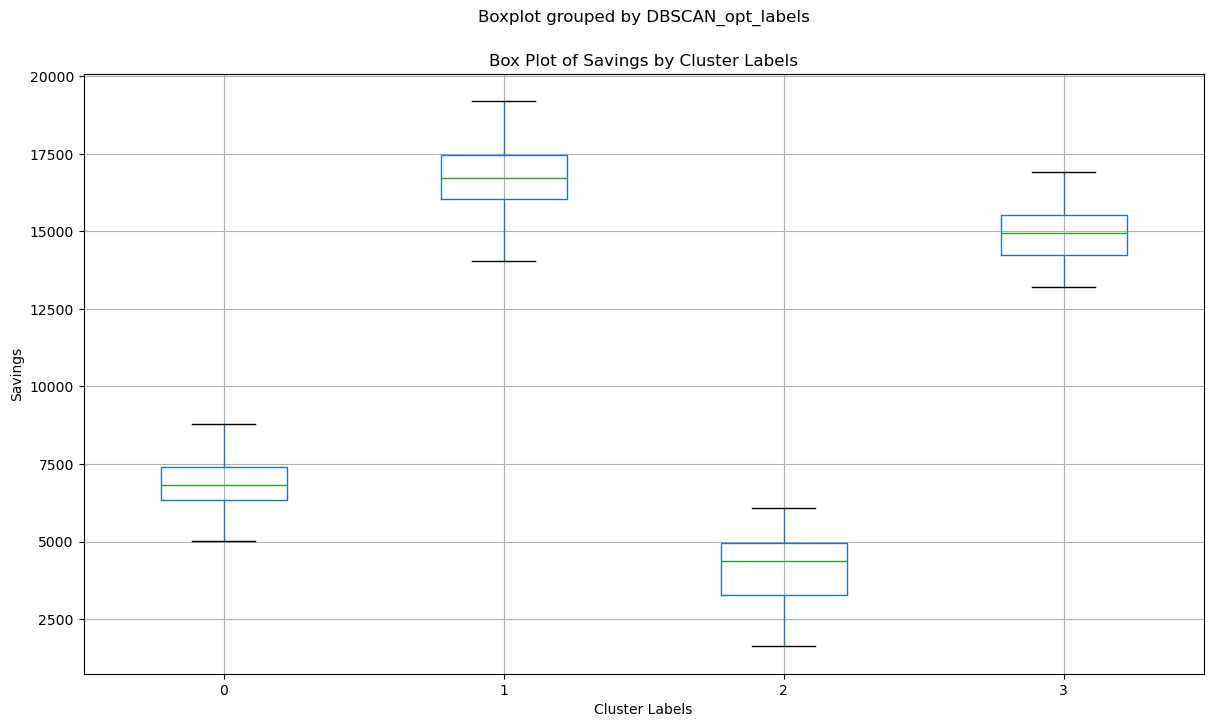

In [43]:
if isinstance(dataset, pd.core.groupby.DataFrameGroupBy):
    dataset = dataset.groupby('DBSCAN_opt_labels')

# Iterate over each feature
for feature in dataset.columns[:-1]:  # Exclude the last column 'Clustering_labels'
    # Create a new figure for each subplot
    fig, ax = plt.subplots(figsize=(14, 8))  # Adjust the figsize here
    # Create a box plot for the current feature, grouped by the cluster labels
    dataset.boxplot(column=feature, by='DBSCAN_opt_labels', ax=ax)
    # Set plot labels and title
    ax.set_xlabel('Cluster Labels')
    ax.set_ylabel(feature)
    ax.set_title(f'Box Plot of {feature} by Cluster Labels')

plt.show()

In [44]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(dataset)
PCA_ds = pd.DataFrame(pca.transform(dataset), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,426.0,-3.074348e-12,36788.819130,-58799.140538,-41235.158010,329.925546,32518.862534,64585.072992
col2,426.0,1.434696e-12,4402.882520,-7022.252111,-4121.073874,-1255.099372,4737.057978,7260.375517
col3,426.0,2.093266e-15,13.316753,-23.120166,-6.452416,-1.127220,2.712098,59.990721


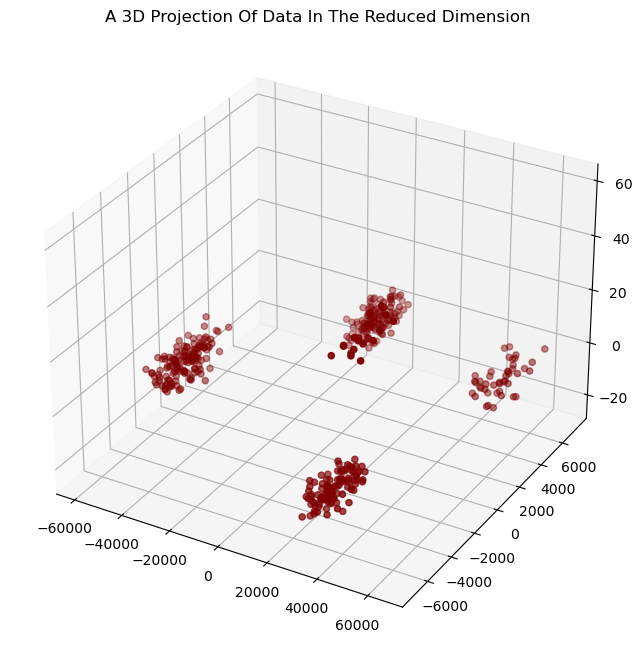

In [45]:
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

In [46]:
# fit model and predict clusters
yhat= dbscan_opt.fit_predict(PCA_ds)
PCA_ds["DBSCAN_opt_labels"] = yhat
#Adding the Clusters feature to the orignal dataframe.
dataset["DBSCAN_opt_labels"]= yhat

/var/folders/wx/ryvwptxd2r3_cfnyq2_0tcrw0000gn/T/ipykernel_83566/1962543879.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


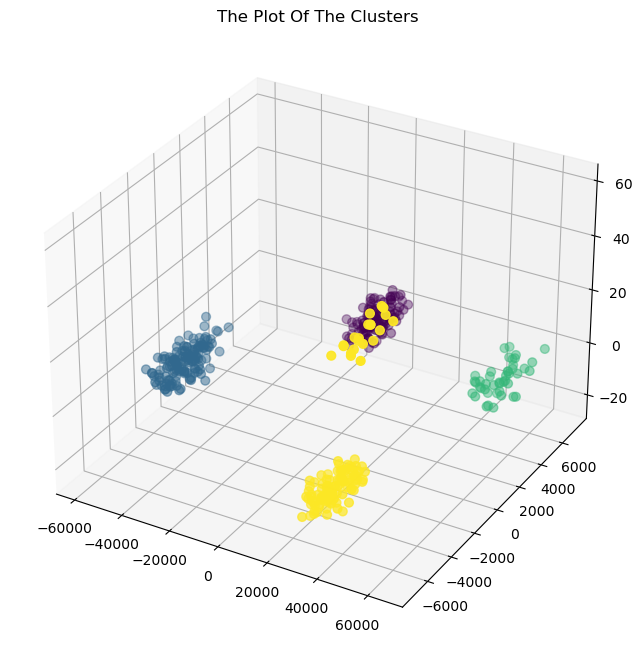

In [47]:
cmap = plt.cm.get_cmap('viridis')
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds["DBSCAN_opt_labels"], marker='o', cmap = cmap )
ax.set_title("The Plot Of The Clusters")
plt.show()

# Model Evaluation

In [48]:
from sklearn import metrics

labels = dbscan_opt.labels_
print ("Silhouette score is :" , metrics.silhouette_score (dataset, labels, metric = 'euclidean'))
print ("Calinski-Harabasz score is :" , metrics.calinski_harabasz_score (dataset, labels))
print ("Davies-Bouldin score is :" , metrics.davies_bouldin_score(dataset, labels))

Silhouette score is : 0.7392173404129369
Calinski-Harabasz score is : 4707.374748467466
Davies-Bouldin score is : 0.3678079384863388
